In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import os
import json
from time import time
import matplotlib.pyplot as plt


# Reads the downsampled dataframe
df = pd.read_csv(os.getcwd()[:os.getcwd().find("Code")] + "/Data/netflix-prize/downsampled-csv/few_samples.csv")
# Reads the json with all the clusters for each user -> This are for a threshold of 0.02. Later, we will tune this threshold
path = os.getcwd()[:os.getcwd().find("Code")] + "/Data/user-clusters/clusters.json"
with open(path, "r") as s:
    clusters = json.loads(s.read())

In [2]:
# Trains and scores regression models for each user
lr = LinearRegression()
r_squared = {}
rf = RandomForestRegressor()
rf_scores = {}
dumb_scores = {}
rg = Ridge()
rg_squared = {}
ada = AdaBoostRegressor()
ada_scores = {}

user_count = 0
problem_users = []
timer = 0
for user in clusters.keys():
    
    start = time()

    # Gets the cluster of users for user
    similar_users_to_user = [int(user) for user in clusters[user].split()]
    # Gets the data for the users in user cluster
    df_user_cluster = df[df["user_id"].isin(similar_users_to_user)]
    df_user = df[df["user_id"].isin([user])]
    
    groups = df_user_cluster.groupby("movie_id")
    movies_avg_rating = groups["rating"].mean()
    df_user = pd.merge(movies_avg_rating, df_user, on="movie_id")
    del df_user["user_id"]
    df_user.columns = ["movie_id", "cluster_avg_rating", "user_rating"]
    
    df_user.replace("?", np.NaN, inplace=True)
    df_user.dropna(inplace=True)
    try:
        if min(df_user["user_rating"].value_counts()) == 1:  # Condition to avoid error on train_test_split
            # ValueError: The least populated class in y has only 1 member, which is too few. 
            # The minimum number of groups for any class cannot be less than 2.
            problem_users.append(user)
        else:
            X = df_user.drop(["user_rating", "movie_id"], axis=1)
            y = df_user["user_rating"]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
            lr.fit(X_train, y_train)
            r_squared[user] = lr.score(X_test, y_test)
            rf.fit(X_train, y_train)
            rf_scores[user] = rf.score(X_test, y_test)
            dumb_scores[user] = r2_score(y_test.values, X_test.values)
            rg.fit(X_train, y_train)
            rg_squared[user] = rg.score(X_test, y_test)
            ada.fit(X_train, y_train)
            ada_scores[user] = ada.score(X_test, y_test)
            
    except Exception as e:
        print("error:", e, user)

    timer += time() - start
    user_count += 1
    if user_count % 100 == 0:
        print("We have trained and scored models on", user_count, "users,", 
             "and it has taken", round(timer), "seconds")

/Users/Pedro./anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


error: min() arg is an empty sequence 1367949
error: min() arg is an empty sequence 2334738
error: min() arg is an empty sequence 984085
error: min() arg is an empty sequence 1430656
error: min() arg is an empty sequence 456966
We have trained and scored models on 100 users, and it has taken 7 seconds
error: min() arg is an empty sequence 665775
error: min() arg is an empty sequence 1050678
We have trained and scored models on 200 users, and it has taken 12 seconds
error: min() arg is an empty sequence 44434
error: min() arg is an empty sequence 2292135
We have trained and scored models on 300 users, and it has taken 19 seconds
error: min() arg is an empty sequence 1569028
error: min() arg is an empty sequence 2597934
We have trained and scored models on 400 users, and it has taken 25 seconds
error: The test_size = 3 should be greater or equal to the number of classes = 4 1948291
We have trained and scored models on 500 users, and it has taken 32 seconds
We have trained and scored mode

In [6]:
for i in [r_squared, rf_scores, dumb_scores, rg_squared, ada_scores]:
    print(np.mean(list(i.values())))

0.6472393236132499
0.6132169574676463
0.6074667998459438
0.6491201671921552
0.5914646141802508


The best one is Ridge, but very close to linear regression. The errors indicate that there cluster for that user is empty, thus we cannot make predictions for this user.

In [7]:
import operator
sorted_r_squared = sorted(r_squared.items(), key=operator.itemgetter(1), reverse=True)
sorted_rg_squared = sorted(rg_squared.items(), key=operator.itemgetter(1), reverse=True)

In [8]:
sorted_r_squared[0]

('2097445', 1.0)

In [9]:
sorted_rg_squared[0]

('2097445', 1.0)

In [10]:
sorted_r_squared[-1]

('1400999', -0.4999999999999998)

In [11]:
sorted_rg_squared[-1]

('18527', -0.4214017206136895)

There are users for which we have perfect $R^2$, while for others it's even negative. This might indicate that these users are rating the movies at random or they just are very inconsistent with their ratings.

In [12]:
for i in [r_squared, rf_scores, dumb_scores, rg_squared, ada_scores]:
    print(np.std(list(i.values())))

0.2279673909465717
0.2526222929373138
0.31846930917743177
0.22018118085766794
0.2742871802989088


The standard deviations are very high. Again, Ridge is the best.

Let's experiment with different thesholds to see which one works best. To do that, we need to load all the distances

In [14]:
distances = {}
os.chdir(os.getcwd()[:os.getcwd().find("Code")] + "Data/user-clusters/user-distances/")
for user in [user for user in os.listdir() if ".json" in user]:
    path = os.getcwd() + "/" + user
    with open(path, "r") as s:
        distances[user[5:user.find(".json")]] = json.loads(s.read())

# Back to the original working directory
os.chdir(os.getcwd()[:os.getcwd().find("/Data")] + "/Code/preprocessing")

In [15]:
clusters = {}
keys = []
for key, value in distances.items():
    clusters[key] = " ".join([keyy for keyy, valuee in value.items() if float(valuee) <= 0.01])
    for i in keys:
        if key in clusters[i]:
            clusters[key] += " " + str(i)
    keys.append(key)

In [16]:
# Trains and scores a basic linear regression model for each user
lr = LinearRegression()
r_squared = {}
rf = RandomForestRegressor()
rf_scores = {}
dumb_scores = {}
rg = Ridge()
rg_squared = {}
ada = AdaBoostRegressor()
ada_scores = {}

user_count = 0
problem_users = []
timer = 0
for user in clusters.keys():
    
    start = time()

    # Gets the cluster of users for user
    similar_users_to_user = [int(user) for user in clusters[user].split()]
    # Gets the data for the users in user cluster
    df_user_cluster = df[df["user_id"].isin(similar_users_to_user)]
    df_user = df[df["user_id"].isin([user])]
    
    groups = df_user_cluster.groupby("movie_id")
    movies_avg_rating = groups["rating"].mean()
    df_user = pd.merge(movies_avg_rating, df_user, on="movie_id")
    del df_user["user_id"]
    df_user.columns = ["movie_id", "cluster_avg_rating", "user_rating"]
    
    df_user.replace("?", np.NaN, inplace=True)
    df_user.dropna(inplace=True)
    try:
        if min(df_user["user_rating"].value_counts()) == 1:  # Condition to avoid error on train_test_split
            # ValueError: The least populated class in y has only 1 member, which is too few. 
            # The minimum number of groups for any class cannot be less than 2.
            problem_users.append(user)
        else:
            X = df_user.drop(["user_rating", "movie_id"], axis=1)
            y = df_user["user_rating"]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
            lr.fit(X_train, y_train)
            r_squared[user] = lr.score(X_test, y_test)
            rf.fit(X_train, y_train)
            rf_scores[user] = rf.score(X_test, y_test)
            dumb_scores[user] = r2_score(y_test.values, X_test.values)
            rg.fit(X_train, y_train)
            rg_squared[user] = rg.score(X_test, y_test)
            ada.fit(X_train, y_train)
            ada_scores[user] = ada.score(X_test, y_test)
            
    except Exception as e:
        print("error:", e, user)

    timer += time() - start
    user_count += 1
    if user_count % 100 == 0:
        print("We have trained and scored models on", user_count, "users,", 
             "and it has taken", round(timer), "seconds")

/Users/Pedro./anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


error: min() arg is an empty sequence 1220994
error: min() arg is an empty sequence 1814740
error: min() arg is an empty sequence 507540
error: min() arg is an empty sequence 1947739
error: min() arg is an empty sequence 984085
We have trained and scored models on 100 users, and it has taken 5 seconds
error: min() arg is an empty sequence 2251285
error: min() arg is an empty sequence 2292135
error: min() arg is an empty sequence 2053064
error: min() arg is an empty sequence 665775
error: min() arg is an empty sequence 157711
error: min() arg is an empty sequence 1166047
error: min() arg is an empty sequence 1948291
error: min() arg is an empty sequence 2546654
We have trained and scored models on 200 users, and it has taken 9 seconds
error: min() arg is an empty sequence 1154874
error: min() arg is an empty sequence 1116187
error: min() arg is an empty sequence 946528
error: min() arg is an empty sequence 2126379
error: min() arg is an empty sequence 1751912
error: min() arg is an empt

In [17]:
for i in [r_squared, rf_scores, dumb_scores, rg_squared, ada_scores]:
    print(np.mean(list(i.values())))

0.7626131524004701
0.7455724510295917
0.7689974176342519
0.759818615804655
0.682264827860792


A smaller threshold means better precission, but it also means we will have predictions for less movies, because each user will have a smaller cluster and thus less movies which his cluster has watched. The dataset for each user will become smaller, and thus our ability to train and evaluate the models will decrease.

In [18]:
clusters = {}
keys = []
for key, value in distances.items():
    clusters[key] = " ".join([keyy for keyy, valuee in value.items() if float(valuee) <= 0.03])
    for i in keys:
        if key in clusters[i]:
            clusters[key] += " " + str(i)
    keys.append(key)

In [19]:
# Trains and scores a basic linear regression model for each user
lr = LinearRegression()
r_squared = {}
rf = RandomForestRegressor()
rf_scores = {}
dumb_scores = {}
rg = Ridge()
rg_squared = {}
ada = AdaBoostRegressor()
ada_scores = {}

user_count = 0
problem_users = []
timer = 0
for user in clusters.keys():
    
    start = time()

    # Gets the cluster of users for user
    similar_users_to_user = [int(user) for user in clusters[user].split()]
    # Gets the data for the users in user cluster
    df_user_cluster = df[df["user_id"].isin(similar_users_to_user)]
    df_user = df[df["user_id"].isin([user])]
    
    groups = df_user_cluster.groupby("movie_id")
    movies_avg_rating = groups["rating"].mean()
    df_user = pd.merge(movies_avg_rating, df_user, on="movie_id")
    del df_user["user_id"]
    df_user.columns = ["movie_id", "cluster_avg_rating", "user_rating"]
    
    df_user.replace("?", np.NaN, inplace=True)
    df_user.dropna(inplace=True)
    try:
        if min(df_user["user_rating"].value_counts()) == 1:  # Condition to avoid error on train_test_split
            # ValueError: The least populated class in y has only 1 member, which is too few. 
            # The minimum number of groups for any class cannot be less than 2.
            problem_users.append(user)
        else:
            X = df_user.drop(["user_rating", "movie_id"], axis=1)
            y = df_user["user_rating"]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
            lr.fit(X_train, y_train)
            r_squared[user] = lr.score(X_test, y_test)
            rf.fit(X_train, y_train)
            rf_scores[user] = rf.score(X_test, y_test)
            dumb_scores[user] = r2_score(y_test.values, X_test.values)
            rg.fit(X_train, y_train)
            rg_squared[user] = rg.score(X_test, y_test)
            ada.fit(X_train, y_train)
            ada_scores[user] = ada.score(X_test, y_test)
            
    except Exception as e:
        print("error:", e, user)

    timer += time() - start
    user_count += 1
    if user_count % 100 == 0:
        print("We have trained and scored models on", user_count, "users,", 
             "and it has taken", round(timer), "seconds")

/Users/Pedro./anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


We have trained and scored models on 100 users, and it has taken 7 seconds
We have trained and scored models on 200 users, and it has taken 14 seconds
We have trained and scored models on 300 users, and it has taken 20 seconds
We have trained and scored models on 400 users, and it has taken 27 seconds
We have trained and scored models on 500 users, and it has taken 34 seconds
We have trained and scored models on 600 users, and it has taken 40 seconds
We have trained and scored models on 700 users, and it has taken 47 seconds
We have trained and scored models on 800 users, and it has taken 55 seconds
We have trained and scored models on 900 users, and it has taken 61 seconds
We have trained and scored models on 1000 users, and it has taken 68 seconds
We have trained and scored models on 1100 users, and it has taken 74 seconds
We have trained and scored models on 1200 users, and it has taken 80 seconds
We have trained and scored models on 1300 users, and it has taken 88 seconds
error: mi

In [20]:
for i in [r_squared, rf_scores, dumb_scores, rg_squared, ada_scores]:
    print(np.mean(list(i.values())))

0.5542290976302072
0.4981641058713521
0.5143390173650783
0.5547011657342846
0.5013075885698063


Number of movies for each user's dataset

In [73]:
path = os.getcwd()[:os.getcwd().find("Code")] + "/Data/user-clusters/clusters.json"
with open(path, "r") as s:
    clusters = json.loads(s.read())  

n_movies = []
timer = 0
user_count = 0
for user in clusters.keys():
    start = time()
    similar_users_to_user = [int(user) for user in clusters[user].split()]
    # Gets the data for the users in user cluster
    df_user_cluster = df[df["user_id"].isin(similar_users_to_user)]
    n_movies.append(len(df_user_cluster.groupby("movie_id")))
    
    timer += time() - start
    user_count += 1
    if user_count % 100 == 0:
        print(user_count, "users,", round(timer), "seconds")

100 users, 9 seconds
200 users, 18 seconds
300 users, 26 seconds
400 users, 33 seconds
500 users, 43 seconds
600 users, 53 seconds
700 users, 70 seconds
800 users, 84 seconds
900 users, 100 seconds
1000 users, 121 seconds
1100 users, 147 seconds
1200 users, 165 seconds
1300 users, 184 seconds
1400 users, 206 seconds
1500 users, 231 seconds
1600 users, 253 seconds
1700 users, 280 seconds
1800 users, 304 seconds
1900 users, 329 seconds


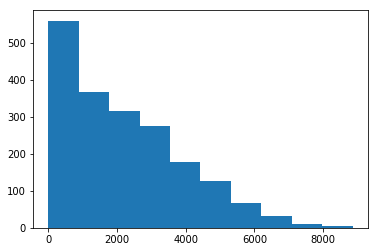

In [74]:
plt.hist(n_movies)
plt.show()

In [76]:
np.mean(n_movies)

2202.797311271975

In [82]:
timer = 0
user_count = 0
n_movies_with_ratings = []
for user in clusters.keys():
    start = time()
    similar_users_to_user = [int(user) for user in clusters[user].split()]
    # Gets the data for the users in user cluster
    df_user_cluster = df[df["user_id"].isin(similar_users_to_user)]
    df_user = df[df["user_id"].isin([user])]
    groups = df_user_cluster.groupby("movie_id")
    movies_avg_rating = groups["rating"].mean()
    df_user = pd.merge(movies_avg_rating, df_user, on="movie_id")
    del df_user["user_id"]
    df_user.columns = ["movie_id", "cluster_avg_rating", "user_rating"]
    
    df_user.replace("?", np.NaN, inplace=True)
    df_user.dropna(inplace=True)
    n_movies_with_ratings.append(df_user.shape[0])
    
    timer += time() - start
    user_count += 1
    if user_count % 100 == 0:
        print(user_count, "users,", round(timer), "seconds")

100 users, 4 seconds
200 users, 7 seconds
300 users, 10 seconds
400 users, 13 seconds
500 users, 17 seconds
600 users, 21 seconds
700 users, 25 seconds
800 users, 29 seconds
900 users, 34 seconds
1000 users, 38 seconds
1100 users, 44 seconds
1200 users, 50 seconds
1300 users, 55 seconds
1400 users, 60 seconds
1500 users, 65 seconds
1600 users, 68 seconds
1700 users, 71 seconds
1800 users, 75 seconds
1900 users, 78 seconds


In [83]:
np.mean(n_movies_with_ratings)

72.60186142709411

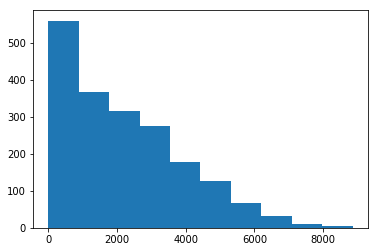

In [84]:
plt.hist(n_movies)
plt.show()